iter= 0 , loss= 0.7288758
iter= 1 , loss= 0.6600135
iter= 2 , loss= 0.597519
iter= 3 , loss= 0.5410257
iter= 4 , loss= 0.49012497
iter= 5 , loss= 0.44441026
iter= 6 , loss= 0.40349776
iter= 7 , loss= 0.3670215
iter= 8 , loss= 0.3346309
iter= 9 , loss= 0.30599013
iter= 10 , loss= 0.2807776
iter= 11 , loss= 0.25868657
iter= 12 , loss= 0.23942658
iter= 13 , loss= 0.22272666
iter= 14 , loss= 0.20833664
iter= 15 , loss= 0.19602703
iter= 16 , loss= 0.18558705
iter= 17 , loss= 0.17682232
iter= 18 , loss= 0.16955237
iter= 19 , loss= 0.16360842
iter= 20 , loss= 0.15883154
iter= 21 , loss= 0.15507145
iter= 22 , loss= 0.15218575
iter= 23 , loss= 0.15004018
iter= 24 , loss= 0.148509
iter= 25 , loss= 0.14747599
iter= 26 , loss= 0.14683557
iter= 27 , loss= 0.14649336
iter= 28 , loss= 0.14636667
iter= 29 , loss= 0.14638455
iter= 30 , loss= 0.14648768
iter= 31 , loss= 0.14662862
iter= 32 , loss= 0.14677139
iter= 33 , loss= 0.14689103
iter= 34 , loss= 0.14697246
iter= 35 , loss= 0.14700855
iter= 36 , l

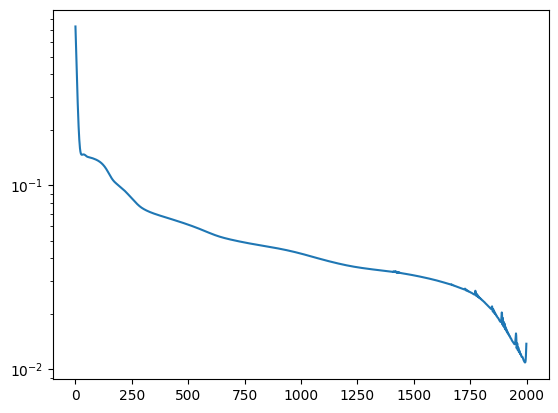

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import qmc  # LHS를 위해 추가

class Burgers(Model):  # 인공신경망 정의 클래스
    def __init__(self):
        super(Burgers, self).__init__()
        self.h1 = Dense(20, activation='tanh')
        self.h2 = Dense(20, activation='tanh')
        self.h3 = Dense(20, activation='tanh')
        self.h4 = Dense(20, activation='tanh')
        self.h5 = Dense(20, activation='tanh')
        self.h6 = Dense(20, activation='tanh')
        self.h7 = Dense(20, activation='tanh')
        self.h8 = Dense(20, activation='tanh')
        self.u = Dense(1, activation='linear')  # 출력층

    def call(self, state):
        x = self.h1(state)
        x = self.h2(x)
        x = self.h3(x)
        x = self.h4(x)
        x = self.h5(x)
        x = self.h6(x)
        x = self.h7(x)
        x = self.h8(x)
        out = self.u(x)
        return out


class Pinn(object):  # PINN 모델 클래스
    def __init__(self):
        self.lr = 5e-4
        self.opt = Adam(self.lr)
        self.burgers = Burgers()

    @tf.function
    def physics_net(self, xt):
        x = xt[:, 0:1]
        t = xt[:, 1:2]
        xt_t = tf.concat([x, t], axis=1)
        u = self.burgers(xt_t)
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_t = tf.gradients(u, t)[0]
        return u_t + u * u_x - (0.01 / np.pi) * u_xx

    def save_weights(self, path):
        self.burgers.save_weights(path + 'burgers.weights.h5')

    def load_weights(self, path):
        self.burgers.load_weights(path + 'burgers.weights.h5')

    def learn(self, xt_col, xt_bnd, tu_bnd):
        with tf.GradientTape() as tape:
            f = self.physics_net(xt_col)
            loss_col = tf.reduce_mean(tf.square(f))
            tu_bnd_hat = self.burgers(xt_bnd)
            loss_bnd = tf.reduce_mean(tf.square(tu_bnd_hat - tu_bnd))
            loss = loss_col + loss_bnd

        grads = tape.gradient(loss, self.burgers.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.burgers.trainable_variables))
        return loss

    def predict(self, xt):
        tu = self.burgers(xt)
        return tu

    def train(self, max_num):
        # 경계 및 초기 조건 데이터 생성
        engine = qmc.LatinHypercube(d=1)

        # Initial condition
        x_data = engine.random(n=100)
        x_data = 2 * (x_data - 0.5)  # [-1, 1] 범위로 스케일링
        t_data = np.zeros_like(x_data)
        xt_bnd_data = [[x[0], 0] for x in x_data]
        tu_bnd_data = [[-np.sin(np.pi * x[0])] for x in x_data]

        # Boundary condition
        t_bnd = engine.random(n=100).reshape(-1, 1)
        for t in t_bnd:
            xt_bnd_data.append([1, t[0]])   # x = 1 경계 조건
            tu_bnd_data.append([0])
            xt_bnd_data.append([-1, t[0]])  # x = -1 경계 조건
            tu_bnd_data.append([0])

        xt_bnd_data = np.array(xt_bnd_data)
        tu_bnd_data = np.array(tu_bnd_data)

        # Collocation points using LHS
        engine = qmc.LatinHypercube(d=2)
        xt_col_data = engine.random(n=10000)
        xt_col_data[:, 0] = 2 * (xt_col_data[:, 0] - 0.5)  # x 값 스케일링
        xt_col_data[:, 1] = xt_col_data[:, 1]  # t 값은 [0, 1] 범위 유지

        train_loss_history = []
        for iter in range(int(max_num)):
            loss = self.learn(
                tf.convert_to_tensor(xt_col_data, dtype=tf.float32),
                tf.convert_to_tensor(xt_bnd_data, dtype=tf.float32),
                tf.convert_to_tensor(tu_bnd_data, dtype=tf.float32)
            )
            train_loss_history.append([iter, loss.numpy()])
            print('iter=', iter, ', loss=', loss.numpy())

        self.save_weights("./save_weights/")
        np.savetxt('./save_weights/loss.txt', train_loss_history)
        train_loss_history = np.array(train_loss_history)

        plt.plot(train_loss_history[:, 0], train_loss_history[:, 1])
        plt.yscale("log")
        plt.show()


def main():
    max_num = 2000
    agent = Pinn()
    agent.train(max_num)


if __name__ == "__main__":
    main()


iteration에 따른 loss의 그래프

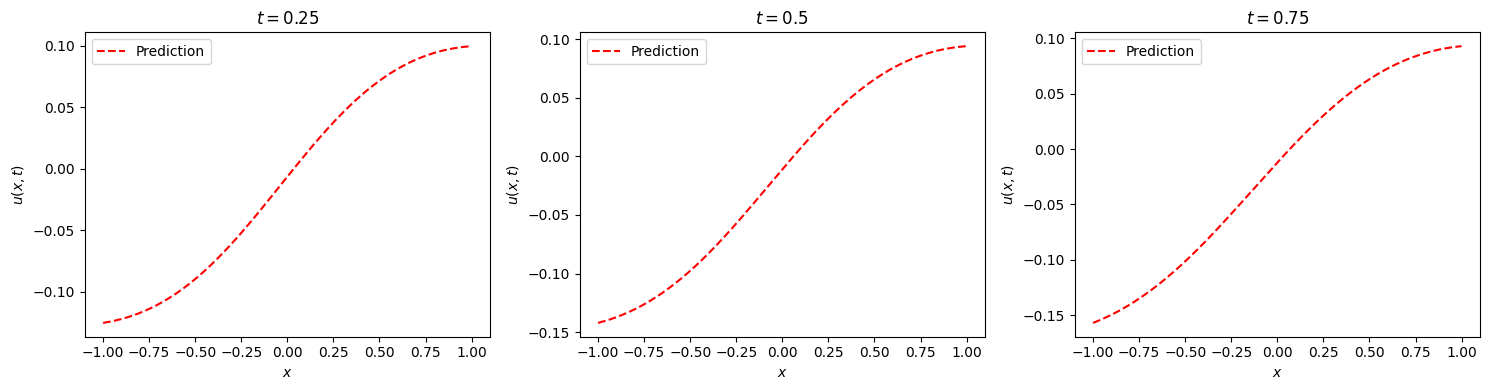

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 고정된 t 값들
t_values = [0.25, 0.5, 0.75]
x_values = np.linspace(-1, 1, 500)

# PINN 모델 초기화 및 가중치 로드
agent = Pinn()  # Pinn 모델 초기화
agent.load_weights("./save_weights/")  # 저장된 가중치 로드

plt.figure(figsize=(15, 4))  # 플롯 크기 설정

for i, fixed_t in enumerate(t_values, 1):
    # t가 고정된 상태에서 x 값에 따른 (x, t) 데이터 생성
    xt_values = np.array([[x, fixed_t] for x in x_values], dtype=np.float32)
    
    # 예측 수행
    predicted_u = agent.predict(tf.convert_to_tensor(xt_values))
    predicted_u = predicted_u.numpy().flatten()  # 1D 배열로 변환
    
    # 그래프 그리기
    plt.subplot(1, len(t_values), i)
    plt.plot(x_values, predicted_u, 'r--', label="Prediction")
    plt.xlabel(r'$x$')
    plt.ylabel(r'$u(x, t)$')
    plt.title(r'$t = {}$'.format(fixed_t))
    plt.legend()

plt.tight_layout()
plt.show()
